In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import default_rng

random_seed = 42
rng = default_rng(random_seed)

In [2]:
n_samples = 50

# X_df = pd.DataFrame(
#     np.array([
#         rng.standard_normal(size=n_samples),
#         rng.exponential(size=n_samples),
#         st.halfcauchy.rvs(scale=10, size=n_samples, random_state=random_seed),
#     ]).T
# )

X_df = pd.DataFrame(
    [[-1, 0, 1, 0, -1],
     [-1, 0, 1, 0, 2],
     [-1, 0, 1, 0, 100]]
).T

X_df.head()

,0,1,2
0,-1,-1,-1
1,0,0,0
2,1,1,1
3,0,0,0
4,-1,2,100


<AxesSubplot:xlabel='2', ylabel='Count'>

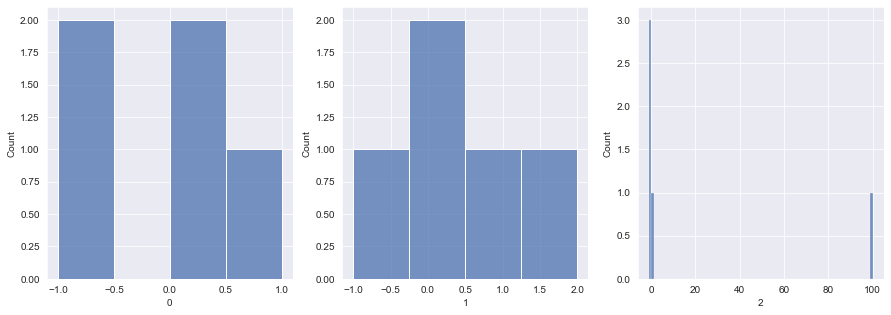

In [3]:
sns.set({'figure.figsize': (15, 5)})
fig, axarr = plt.subplots(1, 3)

sns.histplot(X_df.iloc[:, 0], ax=axarr[0])
sns.histplot(X_df.iloc[:, 1], ax=axarr[1])
sns.histplot(X_df.iloc[:, 2], ax=axarr[2])

In [4]:
def generate_feature_weights(feature_df, weights_type='MAD'):
    """Generate feature weights from data.
    
    feature_df is a dataframe where columns are features, and rows can
    be any values deemed relevant to feature selection.
    
    Options for weights_type:
      - 'MAD': mean absolute deviation of rows
      - 'max LOF': local outlier factor of max row value
      - 'average LOF': average local outlier factor across rows
      - 'kurtosis': kurtosis of distribution across rows
    """
    if weights_type == 'MAD':
        weights = feature_df.mad(axis=0).values
    elif weights_type == 'max LOF':
        from sklearn.neighbors import LocalOutlierFactor
        
        def column_to_max_lof(col):
            max_ix = col.idxmax()
            max_value = col.max()
            lof = LocalOutlierFactor(n_neighbors=2,
                                     contamination='auto')
            lof.fit_predict(
                col.values.reshape(-1, 1)
            )
            max_lof = lof.negative_outlier_factor_[
                col.index.get_loc(max_ix)
            ]
            return max_lof
            
        weights = (feature_df
          .apply(column_to_max_lof, axis='index')
          .to_numpy()
        )
    elif weights_type == 'average LOF':
        from sklearn.neighbors import LocalOutlierFactor
        
        def column_to_avg_lof(col):
            lof = LocalOutlierFactor(n_neighbors=2,
                                     contamination='auto')
            lof.fit_predict(
                col.values.reshape(-1, 1)
            )
            return np.mean(lof.negative_outlier_factor_)
        
        weights = (feature_df
          .apply(column_to_avg_lof, axis='index')
          .to_numpy()
        )
    elif weights_type == 'kurtosis':
        weights = (feature_df
          .apply(st.kurtosis, axis='index')
          .to_numpy()
        )
        # min-max scale the kurtosis since it's relative to
        # a normal distribution defined as 0, the negative/
        # positive values don't have meaning to us
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        scaler.fit(weights.reshape(-1, 1))
        weights = scaler.transform(weights.reshape(-1, 1)).flatten()
        
    # should have one weight per feature
    assert weights.shape[0] == feature_df.shape[1]
    
    return weights

In [5]:
print(generate_feature_weights(X_df))

[ 0.64  0.88 32.  ]


In [6]:
print(generate_feature_weights(X_df, weights_type='max LOF'))

[ -1.          -1.5        -99.49999999]


In [7]:
print(generate_feature_weights(X_df, weights_type='average LOF'))

[ -1.   -1.1 -20.7]


In [8]:
print(generate_feature_weights(X_df, weights_type='kurtosis'))

[0.         0.07753004 1.        ]
